# IEEE-CIS Fraud Detection - Kaggle

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

import gc, datetime, random

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


We are supposed to output the probability of a transaction being fraudulant. 

Now, we will load the train and test data.

In [2]:
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [3]:
train_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
train_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [6]:
print(f'Train dataset: {train.shape[0]} rows & {train.shape[1]} columns')
print(f'Test dataset: {test.shape[0]} rows & {test.shape[1]} columns')

Train dataset: 590540 rows & 434 columns
Test dataset: 506691 rows & 433 columns


## Reduce Mamory

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [9]:
del train_identity, train_transaction, test_identity, test_transaction

## Find categorical and numerical attributes

Now let us find the categorical data and numerical data.

In [10]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

# Find missing data

In [11]:
data_null = train.isnull().sum()/len(train) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data.head()

,Missing Ratio
id_24,99.196159
id_25,99.130965
id_07,99.127070
id_08,99.127070
id_21,99.126393


In [12]:
missing_data.shape

(414, 1)

There are 414 attributes containing null values. We will delete the columns with more than 90% missing values

In [13]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

In [14]:
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

In [15]:
def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove('isFraud')
    return cols_to_drop

In [16]:
cols_to_drop = get_useless_columns(train)

More than 90% null: 12
More than 90% repeated value: 67


## EDA

In [17]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64

As you can see, 88% of values are missing and 10% of them are equal to 0. So, 98% of data is either missing or 0. This attribute does not seem to be helpful.

In [18]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

NaN         0.761273
100.0000    0.225492
95.0625     0.002112
95.1875     0.001360
97.1250     0.000957
Name: id_11, dtype: float64

Here we see that 76% of data is missing and more that 22% is equal to 100. This does not seem useful either.

In [19]:
list(train.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

### ID

In [20]:
for i in range(1, 10):
    print(train['id_0' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')
    
for i in range(10, 39):
    print(train['id_' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

 NaN     0.755761
-5.0     0.139144
 0.0     0.033114
-10.0    0.019062
-20.0    0.018984
Name: id_01, dtype: float64


NaN       0.761452
1102.0    0.000019
696.0     0.000017
1116.0    0.000015
1120.0    0.000015
Name: id_02, dtype: float64


NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64


 NaN    0.887689
 0.0    0.111320
-5.0    0.000224
-6.0    0.000166
-8.0    0.000108
Name: id_04, dtype: float64


NaN    0.768238
0.0    0.157048
1.0    0.014043
2.0    0.008360
3.0    0.006526
Name: id_05, dtype: float64


 NaN    0.768238
 0.0    0.154647
-1.0    0.007937
-5.0    0.006518
-6.0    0.005515
Name: id_06, dtype: float64


NaN     0.991271
0.0     0.000693
16.0    0.000415
14.0    0.000386
12.0    0.000352
Name: id_07, dtype: float64


 NaN      0.991271
-100.0    0.000847
 0.0      0.000442
-34.0     0.000435
-33.0     0.000354
Name: id_08, dtype: float64


NaN    0.873123
0.0    0.119176
1.0    0.002736
3.0    0.001636
2

Let's visualize the categorical ones which are:

['id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38']

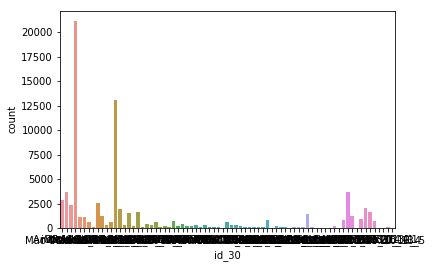

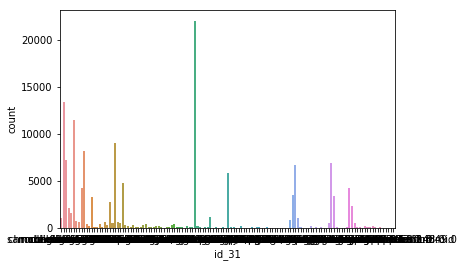

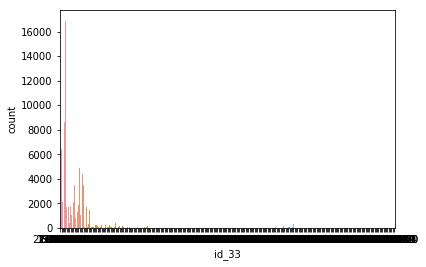

In [21]:
info = []
for i in range(12, 39):
    info.append('id_' + str(i))
for i in info:
    if i in ['id_30', 'id_31', 'id_33']:
        plt.figure(i)
        sns.countplot(x=train[i], data=train)

### DeviceType and DeviceInfo

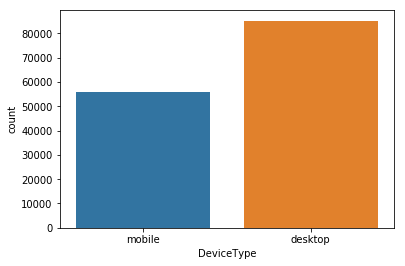

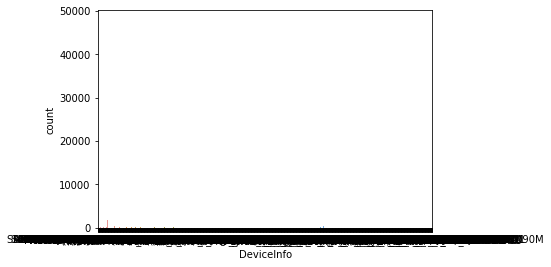

In [22]:
for i in ['DeviceType', 'DeviceInfo']:
    plt.figure(i)
    sns.countplot(x=train[i], data=train)

### Date

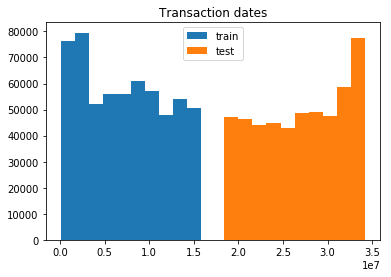

In [23]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Transaction dates');

Above, it is shown that the dates of Train and Test data have an empty intersection.

### Card

In [24]:
for i in range(1, 7):
    print(train['card' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
Name: card1, dtype: float64


321.0    0.082865
111.0    0.076525
555.0    0.071113
490.0    0.064593
583.0    0.036920
Name: card2, dtype: float64


150.0    0.882729
185.0    0.095414
106.0    0.002660
NaN      0.002650
146.0    0.002120
Name: card3, dtype: float64


visa                0.651551
mastercard          0.320414
american express    0.014102
discover            0.011263
NaN                 0.002670
Name: card4, dtype: float64


226.0    0.502161
224.0    0.138031
166.0    0.096759
102.0    0.049285
117.0    0.043928
Name: card5, dtype: float64


debit              0.744976
credit             0.252288
NaN                0.002660
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64




### C

In [25]:
for i in range(1, 15):
    print(train['C' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

1.0    0.536443
2.0    0.177924
3.0    0.086895
4.0    0.048845
5.0    0.030348
Name: C1, dtype: float64


1.0    0.535545
2.0    0.176022
3.0    0.087666
4.0    0.047839
5.0    0.028738
Name: C2, dtype: float64


0.0    0.995887
1.0    0.003619
2.0    0.000305
3.0    0.000098
4.0    0.000012
Name: C3, dtype: float64


0.0    0.765203
1.0    0.189347
2.0    0.022004
3.0    0.008380
4.0    0.003221
Name: C4, dtype: float64


0.0    0.630669
1.0    0.208086
2.0    0.058888
3.0    0.022334
4.0    0.011562
Name: C5, dtype: float64


1.0    0.578372
2.0    0.145804
0.0    0.083087
3.0    0.060098
4.0    0.030150
Name: C6, dtype: float64


0.0    0.885871
1.0    0.087997
2.0    0.012385
3.0    0.003443
4.0    0.001878
Name: C7, dtype: float64


0.0    0.758064
1.0    0.177793
2.0    0.026970
3.0    0.009302
4.0    0.004770
Name: C8, dtype: float64


1.0    0.387676
0.0    0.311232
2.0    0.131793
3.0    0.055043
4.0    0.027426
Name: C9, dtype: float64


0.0    0.767843
1.0    0.169728
2.0  

### D

In [26]:
for i in range(1, 16):
    print(train['D' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

0.0    0.474362
1.0    0.014621
2.0    0.008414
3.0    0.006696
4.0    0.006045
Name: D1, dtype: float64


NaN    0.475492
0.0    0.025610
1.0    0.011268
2.0    0.007542
3.0    0.006227
Name: D2, dtype: float64


NaN    0.445149
0.0    0.123775
1.0    0.035998
2.0    0.023350
7.0    0.022556
Name: D3, dtype: float64


NaN    0.286047
0.0    0.282066
1.0    0.009000
2.0    0.005732
3.0    0.004355
Name: D4, dtype: float64


NaN    0.524674
0.0    0.110707
1.0    0.025878
2.0    0.017347
7.0    0.016483
Name: D5, dtype: float64


NaN      0.876068
0.0      0.077526
1.0      0.002689
256.0    0.001516
2.0      0.001448
Name: D6, dtype: float64


NaN    0.934099
0.0    0.035789
1.0    0.002908
2.0    0.001690
3.0    0.001339
Name: D7, dtype: float64


NaN         0.873123
0.791504    0.002288
0.833496    0.002247
0.875000    0.002208
0.958496    0.002201
Name: D8, dtype: float64


NaN         0.873123
0.791504    0.009124
0.833496    0.008929
0.750000    0.008716
0.708496    0.008690
Name

### M

In [27]:
for i in range(1, 10):
    print(train['M' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

T      0.540886
NaN    0.459071
F      0.000042
Name: M1, dtype: float64


T      0.483402
NaN    0.459071
F      0.057527
Name: M2, dtype: float64


NaN    0.459071
T      0.426273
F      0.114656
Name: M3, dtype: float64


NaN    0.476588
M0     0.332585
M2     0.101373
M1     0.089454
Name: M4, dtype: float64


NaN    0.593494
F      0.224356
T      0.182150
Name: M5, dtype: float64


F      0.385843
T      0.327368
NaN    0.286788
Name: M6, dtype: float64


NaN    0.586353
F      0.357933
T      0.055713
Name: M7, dtype: float64


NaN    0.586331
F      0.262897
T      0.150772
Name: M8, dtype: float64


NaN    0.586331
T      0.348251
F      0.065418
Name: M9, dtype: float64




Let's visualize it.

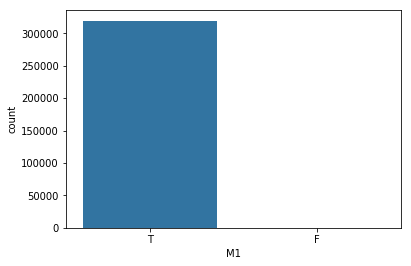

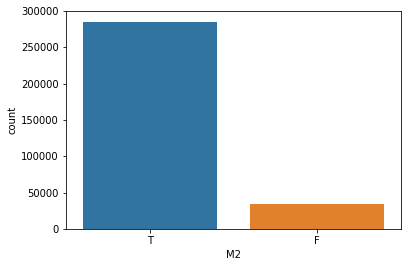

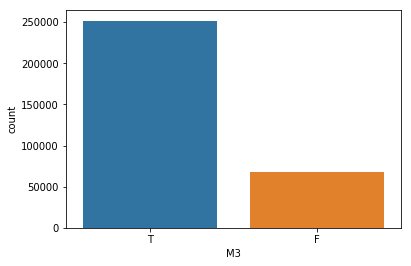

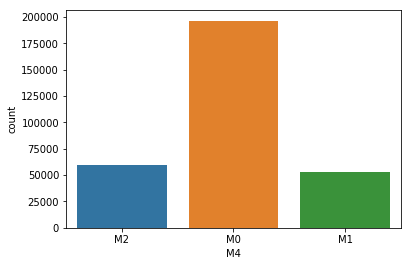

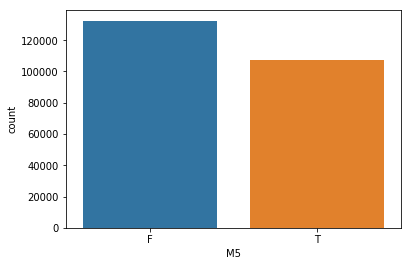

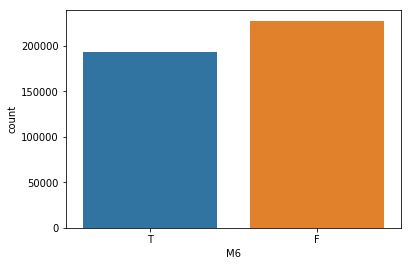

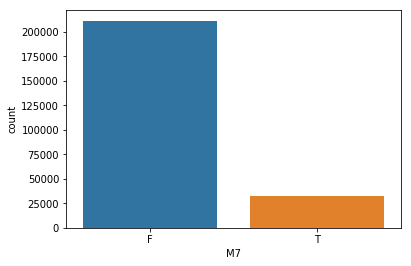

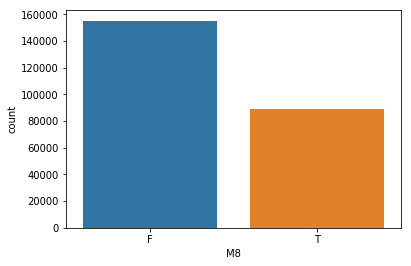

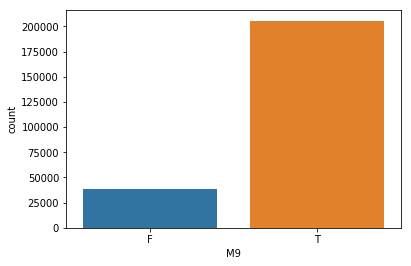

In [28]:
info = []
for i in range(1, 10):
    info.append('M' + str(i))
for i in info:
    plt.figure(i)
    sns.countplot(x=train[i], data=train)

# Feature Engineering

In [29]:
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    
    return data

In [30]:
train = addNewFeatures(train)
test = addNewFeatures(test)

In [31]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

In [32]:
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [33]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

### Handle Email Domains

In [34]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### Handle P Email Domain and R Email Domain

In [35]:
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train=setDomain(train)
test=setDomain(test)

### Handle Browser Version

In [36]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

### Handle Device Type

In [37]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

### Set Frequency

## Prepare Data for Train

In [38]:
train = train.drop(cols_to_drop, axis=1)

In [39]:
class ModifiedLabelEncoder(LabelEncoder):
    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [40]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr):
        self.attributes = attr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes].values

In [41]:
noisy_cols = [
    'TransactionID','TransactionDT',                      # Not target in features))
    'uid','uid2','uid3',                                 
    'id_30','id_31','id_33',
    'D1', 'D2', 'D9',
]

noisy_cat_cols = list(train[noisy_cols].select_dtypes(include=['object']).columns) 
noisy_num_cold = list(train[noisy_cols].select_dtypes(exclude=['object']).columns)

In [42]:
cat_attr = list(train.select_dtypes(include=['object']).columns)
num_attr = list(train.select_dtypes(exclude=['object']).columns)
num_attr.remove('isFraud')

for col in noisy_cat_cols:
    if col in cat_attr:
        print("Deleting " + col)
        cat_attr.remove(col)
for col in noisy_num_cold:
    if col in num_attr:
        print("Deleting " + col)
        num_attr.remove(col)

Deleting uid
Deleting uid2
Deleting uid3
Deleting id_30
Deleting id_31
Deleting id_33
Deleting TransactionID
Deleting TransactionDT
Deleting D1
Deleting D2
Deleting D9


In [43]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attr)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ]) 

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attr)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
    ])


full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

Now we need to deal with categorical data.

In [44]:
def encodeCategorical(df_train, df_test):
    for f in df_train.drop('isFraud', axis=1).columns:
        if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df_train[f].values) + list(df_test[f].values))
            df_train[f] = lbl.transform(list(df_train[f].values))
            df_test[f] = lbl.transform(list(df_test[f].values))
    return df_train, df_test

In [45]:
y_train = train['isFraud']
train, test = encodeCategorical(train, test)

In [46]:
X_train = pd.DataFrame(full_pipeline.fit_transform(train))
gc.collect()

13

In [47]:
del train

## Models

In [48]:
# test = test.drop(cols_to_drop, axis=1)
test = pd.DataFrame(full_pipeline.transform(test))

# Logistic Regression

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [50]:
clf = LogisticRegression(random_state=0, solver='lbfgs',).fit(x_train, y_train)
clf.score(x_test,y_test)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9693296866260602

In [51]:
clf.predict(test)

array([0, 0, 0, ..., 0, 0, 0])

# Grid Search

In [52]:
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='lbfgs', max_iter = 100)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(x_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}
accuracy : 0.9706693356181175


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [53]:
logreg2=LogisticRegression(C=1000,penalty="l2",solver='lbfgs', max_iter = 200)
logreg2.fit(x_train,y_train)
print("score",logreg2.score(x_test,y_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


score 0.9701250519553158


In [54]:
logreg2.predict(test)

array([0, 0, 0, ..., 0, 0, 0])